# Example analysis of a PPG waveform using the vital_sqi package

The following notebook shows an example of PPG waveform processing using the vital_sqi package. The aim of the package is to automate signal quality classification for PPG waveforms. It is achieved by computing various signal quality indices for each signal segment and using them to form a decision. 

## The pipeline can be briefly summarized as follows:
1. Load dataset under analysis
2. Preprocess and segment the dataset
3. Compute SQI for each dataset segment
4. Make decision for each segment

## Global Imports

In [1]:
import numpy as np
import warnings
import pandas as pd 
import matplotlib.pyplot as plt
import vital_sqi

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

### Start by importing the signal via the PPG_reader function

The function expects a .csv or similar data format with named columns. The column names are used to separate between data column, timestamp columns and any additional information columns.
This returns a SignalSQI class that is compatible with other vital_sqi package functions, the main class members of interest are:
* signals:         an ndarray of shape (m, n) where m is the number of rows and n is the number of channels of the signal
* sqi_indexes:     an ndarray of shape (m, n) where m is the number of signal segments, n is the number of SQIs.
* sampling_rate:   sampling rate in hertz (Hz)


In [2]:
from vital_sqi.data.signal_io import PPG_reader

#Prepare variables for analysis
sampling_rate = 100 #Hz
hp_filt_params = (1, 1) #(Hz, order)
lp_filt_params = (20, 4) #(Hz, order)
filter_type =  'butter'
trim_amount = 20 #s
segment_length = 10 #s

file_name = "ppg_smartcare.csv"
ppg_data = PPG_reader(os.path.join("../tests/test_data",file_name),
                      signal_idx=['PLETH'],
                      timestamp_idx= ['TIMESTAMP_MS'],
                      info_idx=['SPO2_PCT','PULSE_BPM','PERFUSION_INDEX'], 
                      timestamp_unit='ms', sampling_rate=sampling_rate, start_datetime=None)

#We have loaded a single data column, therefore we only have 1D timeseries
print(ppg_data.signals)
#Plot a random 10s segment of the signal
s = np.arange(0,1000,1)
fig, ax = plt.subplots()
ax.plot(s, ppg_data.signals['PLETH'][4000:5000])
plt.show()

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

### Filter each signal channel by a band pass filter and trim

The filter_preprocess function applies two digital filters in succession. First high-pass filter followed by a low-pass. The touples used as function parameters stand for cutoff frequency and filter order respectively. Finally, a plot in this example shows the filtered signal centered around 0 as expected.

In [3]:
import vital_sqi.highlevel_functions.highlevel as sqi_hl

sqis = sqi_hl.compute_SQI(ppg_data.signals, 7, 6, ppg_data.wave_type, ppg_data.sampling_rate)
print(sqis)

#raw_signal = np.copy(ppg_data.signals[trim_amount*sampling_rate:-trim_amount*sampling_rate].T) #save the raw signal
#ppg_data.update_signal(sqi_hl.signal_preprocess(signal_channel=ppg_data.signals.T, hp_cutoff_order=hp_filt_params, lp_cutoff_order=lp_filt_params, trim_amount=trim_amount, filter_type=filter_type, sampling_rate=sampling_rate).T)

#print(ppg_data.signals.shape)

#s = np.arange(0,1000,1)
#fig, ax = plt.subplots()
#ax.plot(s, ppg_data.signals.T[0][2000:3000])
#plt.show()

c:\Users\skaro\OneDrive - Imperial College London\PhD\Python_envs\vital_sqi_env\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
c:\Users\skaro\OneDrive - Imperial College London\PhD\Python_envs\vital_sqi_env\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
c:\Users\skaro\OneDrive - Imperial College London\PhD\Python_envs\vital_sqi_env\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
{'first': Timedelta('0 days 00:00:00'), 'last': Timedelta('0 days 00:00:29.990000'), 'snr':

### Split dataset into individual 10s segments

In this example, the sampling rate is 100 Hz, therefore a 10s segment will have 1,000 samples. We want to remove 20s from both the start and the end. The original signal was 23998 samples long. Subtracting 2,000 from both start and end leaves us with 19,998 samples. Unfortunately, this is not easily divisble by 1,000 and therefore we lose another 998 samples from the end. Resulting in 19 segments of 1,000 samples each.

In [4]:
#OLD CODE
#import vital_sqi.data.segment_split as sqi_sg

#ppg_data.update_segment_indices(sqi_sg.generate_segment_idx(segment_length=segment_length, sampling_rate=sampling_rate, signal_array=ppg_data.signals.T).T)
#print(ppg_data.segments.shape)
#print(ppg_data.segments)

(20, 2)
[[    0     0]
 [ 1000  1000]
 [ 2000  2000]
 [ 3000  3000]
 [ 4000  4000]
 [ 5000  5000]
 [ 6000  6000]
 [ 7000  7000]
 [ 8000  8000]
 [ 9000  9000]
 [10000 10000]
 [11000 11000]
 [12000 12000]
 [13000 13000]
 [14000 14000]
 [15000 15000]
 [16000 16000]
 [17000 17000]
 [18000 18000]
 [19000 19000]]


### Example peak detection on one segment
Using the Billauer peak detector we can illustrate the output of the peak detector

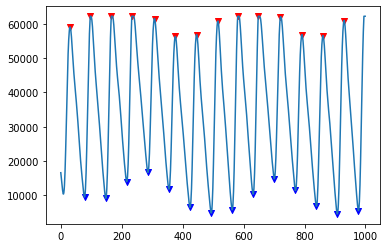

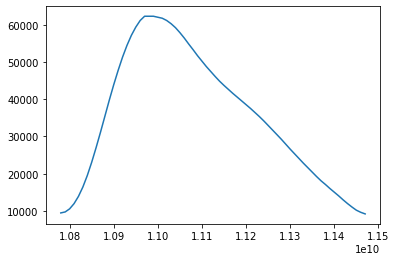

In [4]:
from vital_sqi.common.rpeak_detection import PeakDetector

detector = PeakDetector()
signal_seg = ppg_data.signals['PLETH'][1000:2000]
peak_list, trough_list = detector.ppg_detector(signal_seg, 7)

#Plot results of peak detection
s = np.arange(0,1000,1)
fig, ax = plt.subplots()
ax.plot(s, signal_seg)
if len(peak_list)!=0:
    ax.scatter(peak_list,signal_seg[peak_list],color="r",marker="v")
if len(trough_list)!=0:
    ax.scatter(trough_list,signal_seg[trough_list],color="b",marker="v")
plt.show()
warnings.filterwarnings("ignore")
#Plot a single period
fig, ax = plt.subplots()
ax.plot(signal_seg[trough_list[0]:trough_list[1]])
plt.show()

### Compute array of SQI's for the clean signal

In [6]:
#OLD CODE
#computed_sqi = sqi_hl.compute_all_SQI(signal=ppg_data.signals.T[0], segments=ppg_data.segments.T[0], raw_signal=raw_signal[0], primary_peakdet=7, secondary_peakdet=3, template_type=0)
#ppg_data.update_sqi_indexes(computed_sqi)
#print("\n".join("{}\t{}".format(k, v) for k, v in computed_sqi[0].items()))

peaks	[  4  65 135 207 276 346 415 483 551 622 690 759 829 899 968]
troughs	[ 48 117 186 255 325 394 463 532 601 670 739 809 878 948]
perfusion	140.0372858210069
snr	-0.003319194529139626
zero_cross	0.03
msq	1.0
correlogram	[69, 138, 207, 0.9198667503448775, 0.8516705472464324, 0.7913434662933626]
dtw	[0.9999899062524555, 0.9999897574169484, 0.9999901633765824, 0.9999908525344986, 0.999991386924254, 0.9999919115863259, 0.9999918377727043, 0.9999913381735172, 0.9999891393044283, 0.9999883695655611, 0.9999887116895549]
skewness	0.07994171968115828
skewness_per_beat	[0.2056996018672351, 0.2503997192686091, 0.2601247132803676, 0.2630853156366184, 0.282673110198275, 0.2644854946982527, 0.2445709739646381, 0.3364725168573833, 0.3377466329888228, 0.29074340089004014, 0.2634652150883205]
skewness_mean	0.2726787904307785
skewness_median	0.2634652150883205
skewness_std	0.03680903789889002
kurtosis	-1.0806021162807449
kurtosis_per_beat	[-1.4846151956512972, -1.4375671805722234, -1.440210149815197

### Load a noisy dataset, same way as we loaded the clean dataset in the previous section
Parameters for analysis are the same as for the clean dataset

(5352073, 2)


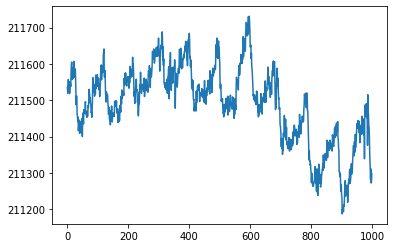

In [7]:
file_name = "ppg_noisy.csv"
ppg_data = PPG_reader(os.path.join("../tests/test_data",file_name),
                      signal_idx=['PLETH', 'IR_ADC'],
                      timestamp_idx= ['TIMESTAMP_MS'],
                      info_idx=['SPO2_PCT','PULSE_BPM','PERFUSION_INDEX'], 
                      timestamp_unit='ms', sampling_rate=sampling_rate, start_datetime=None)

#We have loaded a single data column, therefore we only have 1D timeseries
print(ppg_data.signals.shape)
#Plot a random 10s segment of the signal
start = 4900000
s = np.arange(0,1000,1)
fig, ax = plt.subplots()
ax.plot(s, ppg_data.signals.T[1][start:start+len(s)])
plt.show()

(5348073, 2)


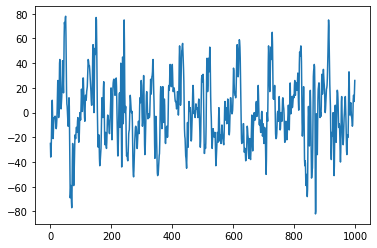

In [8]:
raw_signal = np.copy(ppg_data.signals[trim_amount*sampling_rate:-trim_amount*sampling_rate].T) #save the raw signal
ppg_data.update_signal(sqi_hl.signal_preprocess(signal_channel=ppg_data.signals.T, hp_cutoff_order=hp_filt_params, lp_cutoff_order=lp_filt_params, trim_amount=trim_amount, filter_type=filter_type, sampling_rate=sampling_rate).T)

print(ppg_data.signals.shape)

s = np.arange(0,1000,1)
fig, ax = plt.subplots()
ax.plot(s, ppg_data.signals.T[1][start:start+len(s)])
plt.show()

(5349, 2)


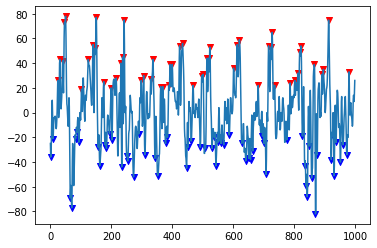

[ 25  31  40  46  50 102 124 140 146 150 175 199 216 231 237 242 298 306
 329 337 362 369 389 393 400 424 434 468 497 501 514 519 523 601 613 620
 682 716 723 728 736 787 802 812 818 822 866 891 896 913 980]


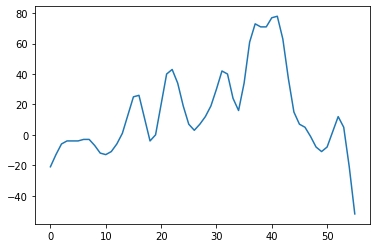

In [9]:
ppg_data.update_segment_indices(sqi_sg.generate_segment_idx(segment_length=segment_length, sampling_rate=sampling_rate, signal_array=ppg_data.signals.T).T)
print(ppg_data.segments.shape)

detector = PeakDetector()
signal_seg = ppg_data.signals.T[1][ppg_data.segments.T[0][4900]:ppg_data.segments.T[0][4901]]
peak_list, trough_list = detector.ppg_detector(signal_seg, 3)

#Plot results of peak detection
s = np.arange(0,1000,1)
fig, ax = plt.subplots()
ax.plot(s, signal_seg)
if len(peak_list)!=0:
    ax.scatter(peak_list,signal_seg[peak_list],color="r",marker="v")
if len(trough_list)!=0:
    ax.scatter(trough_list,signal_seg[trough_list],color="b",marker="v")
plt.show()

print(peak_list)
#Plot a single period
fig, ax = plt.subplots()
ax.plot(signal_seg[trough_list[1]:trough_list[2]])
plt.show()

In [10]:
computed_sqi_noisy = sqi_hl.compute_all_SQI(signal=ppg_data.signals.T[1], segments=ppg_data.segments.T[1][4900:4905], raw_signal=raw_signal[1], primary_peakdet=3, secondary_peakdet=6, template_type=0)
print("\n".join("{}\t{}".format(k, v) for k, v in computed_sqi_noisy[1].items()))
#14  56  68  92 144 245 260 267 304 357 363 389 394 452 458 551 561 584 612 662 687 752 759 764 856 882 943 951

peaks	[ 12  17 100 112 118 123 145 312 317 321 399 419 423 485 502 516 526 611
 618 711 720 815 821 874 888 894 910 920 982 989 996]
troughs	[ 24  32  46  51  59  65  75 134 154 169 188 222 234 247 264 295 325 330
 335 342 355 370 383 430 442 453 461 537 544 556 568 574 577 651 656 668
 727 737 749 755 771 777 830 839 850 858 865 929 933 938 951 962]
perfusion	0.07514783493274235
snr	0.01534708129421352
zero_cross	0.107
msq	0.2246376811594203
correlogram	[31, 101, 124, -0.11754194511902095, 0.5467256595519393, -0.11648860101211726]
dtw	[0.975882804119333, 0.9867013723100375, 0.9888848652186797, 0.9888893604907062, 0.989496707514924, 0.9967031453291406, 0.9958747511976104, 0.9935920640818178, 0.9957779395837653, 0.9937478249088693, 0.9954110784198343, 0.9933176784829425, 0.994841471466011, 0.9903268252888611, 0.9958159506129715, 0.9905308800506665, 0.9921804814881203, 0.973409399457134, 0.9949422507450746, 0.9925746255841513, 0.9903022054114633, 0.9953915271894326, 0.9969669281571942, 0

# Comparison

In [11]:
print("SQI\tClean data\tNoisy data\n")
for k, v in computed_sqi_noisy[1].items():
    print("{}\t{}\t{}\n".format(k,computed_sqi[0][k],v))


SQI	Clean data	Noisy data

peaks	[  4  65 135 207 276 346 415 483 551 622 690 759 829 899 968]	[ 12  17 100 112 118 123 145 312 317 321 399 419 423 485 502 516 526 611
 618 711 720 815 821 874 888 894 910 920 982 989 996]

troughs	[ 48 117 186 255 325 394 463 532 601 670 739 809 878 948]	[ 24  32  46  51  59  65  75 134 154 169 188 222 234 247 264 295 325 330
 335 342 355 370 383 430 442 453 461 537 544 556 568 574 577 651 656 668
 727 737 749 755 771 777 830 839 850 858 865 929 933 938 951 962]

perfusion	140.0372858210069	0.07514783493274235

snr	-0.003319194529139626	0.01534708129421352

zero_cross	0.03	0.107

msq	1.0	0.2246376811594203

correlogram	[69, 138, 207, 0.9198667503448775, 0.8516705472464324, 0.7913434662933626]	[31, 101, 124, -0.11754194511902095, 0.5467256595519393, -0.11648860101211726]

dtw	[0.9999899062524555, 0.9999897574169484, 0.9999901633765824, 0.9999908525344986, 0.999991386924254, 0.9999919115863259, 0.9999918377727043, 0.9999913381735172, 0.9999891393044283, 